In [1]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path
import re
from typing import Iterable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from matplotlib.ticker import PercentFormatter

In [2]:
# ----------------------------------------------------------------------------
# Konstanten
# ----------------------------------------------------------------------------
CSV_PATH = Path("../docs/gemma/validation_attention.csv")  # anpassen falls noetig
MODEL     = "en_core_web_sm"                                # spaCy‑Modell
DEBUG     = False                                           # True fuer Konsolen‑Debug
NEW_CHUNK = re.compile(r"^[▁]|^[\?\!\,\.\:\;]$")      # Beginn neues Token
WH_SET = {
    "what", "which", "who", "whom", "whose",
    "where", "when", "why", "how",
}

POS_TRANSLATION = {
    "NOUN": "Nomen",
    "VERB": "Verb",
    "ADJ":  "Adjektiv",
    "PUNCT": "Satzzeichen",
    "PRON": "Pronomen",
    "DET":  "Determinator",
    "ADV":  "Adverb",
    "OTHER": "Andere",
    "WH":    "Fragewort",
}

In [3]:
# ----------------------------------------------------------------------------
# Hilfsfunktionen
# ----------------------------------------------------------------------------

def pos_bucket(tok_str: str, pos_tag: str) -> str:
    """Ordnet spaCy‑POS oder Token‑String unserem Bucket‑Schema zu."""
    low = tok_str.lower()
    if low in WH_SET:
        return "WH"
    if pos_tag == "ADJ":
        return "ADJ"
    if pos_tag in ("VERB", "AUX"):
        return "VERB"
    if pos_tag == "NOUN":
        return "NOUN"
    if pos_tag == "PRON":
        return "PRON"
    if pos_tag == "DET":
        return "DET"
    if pos_tag == "ADV":
        return "ADV"
    if pos_tag == "PUNCT" or re.fullmatch(r"[\?\!\,\.\:\;]", tok_str):
        return "PUNCT"
    return "OTHER"


def rebuild_tokens(tokens: Iterable[str], scores: Iterable[float]) -> Tuple[List[str], List[float]]:
    """Fasst SentencePiece‑Subtokens zu vollstaendigen Woertern zusammen.

    Die Attention‑Scores der Subtokens werden dabei addiert.
    """
    words: List[str] = []
    sums:  List[float] = []
    cur_word = ""
    cur_score = 0.0

    for tok, sc in zip(tokens, scores):
        if NEW_CHUNK.match(tok):
            # vorheriges Wort abschliessen
            if cur_word:
                words.append(cur_word)
                sums.append(cur_score)
            if tok.startswith("▁"):
                cur_word  = tok.lstrip("▁")
                cur_score = sc
            else:  # reines Satzzeichen -> eigenes Wort
                words.append(tok)
                sums.append(sc)
                cur_word, cur_score = "", 0.0
        else:  # Fortsetzung des aktuellen Wortes
            cur_word  += tok
            cur_score += sc

    # letztes Wort flushen
    if cur_word:
        words.append(cur_word)
        sums.append(cur_score)

    return words, sums


In [4]:
# ----------------------------------------------------------------------------
# Hauptlogik
# ----------------------------------------------------------------------------

def main() -> None:
    # 1) Daten laden
    df = pd.read_csv(CSV_PATH)

    # 2) spaCy‑Pipe initialisieren
    nlp = spacy.load(MODEL, disable=["ner", "parser"])

    # 3) Attention nach POS‑Buckets pro Frage sammeln
    per_sample_percent = []
    for sid, grp in df.groupby("sample_id", sort=False):
        words, scores = rebuild_tokens(grp["token"], grp["score"])
        if not words:
            continue

        doc = nlp(" ".join(words))
        bucket_sum: dict[str, float] = defaultdict(float)
        for w, sc, sp in zip(words, scores, doc):
            bucket_sum[pos_bucket(w, sp.pos_)] += sc

        total_sc = sum(scores)
        sample_percent = {k: v / total_sc for k, v in bucket_sum.items()}
        sample_percent["sample_id"] = sid
        per_sample_percent.append(sample_percent)

        if DEBUG:
            print_sample_debug(sid, grp["question"].iloc[0], words, scores, doc, sample_percent)

    perc_df = pd.DataFrame(per_sample_percent).fillna(0.0)
    bucket_cols = sorted(c for c in perc_df.columns if c != "sample_id")
    mean_percent = perc_df[bucket_cols].mean().sort_values(ascending=False)

    # 4) Ergebnisse ausgeben
    print("\nDurchschnittlicher Attention‑Anteil je Wortart:")
    for cat, val in mean_percent.items():
        print(f"{cat:<6}: {val * 100:6.2f} %")

    plot_pos_buckets(mean_percent)
    plot_pos_buckets(mean_percent.rename(index=POS_TRANSLATION), deutsch=True)

    # 5) Verteilung entlang der Wortposition
    plot_attention_along_sentence(df, nlp)


In [5]:
# ----------------------------------------------------------------------------
# Plot‑Funktionen
# ----------------------------------------------------------------------------

def plot_pos_buckets(series: pd.Series, *, deutsch: bool = False) -> None:
    """Balkendiagramm des durchschnittlichen Attention‑Anteils pro Bucket."""
    title = (
        "Gemittelte Attention pro Wortart (Validation‑Split)"
        if not deutsch
        else "Gemittelte Attention pro Wortart (deutsche Labels)"
    )
    plt.figure(figsize=(8, 4))
    series.plot(kind="bar", color="#4C72B0")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.ylabel("durchschnittlicher Attention‑Anteil")
    if deutsch:
        plt.xlabel("Wortart (Deutsch)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_attention_along_sentence(df: pd.DataFrame, nlp) -> None:
    """Mittelwerte der Attention ueber Satzposition visualisieren."""
    NUM_BINS = 20  # 5‑Prozent‑Schritte
    bins_total = np.zeros(NUM_BINS)
    sample_count = 0

    for _, grp in df.groupby("sample_id", sort=False):
        words, scores = rebuild_tokens(grp["token"], grp["score"])
        if not words:
            continue
        per_bin = np.zeros(NUM_BINS)
        total_sc = sum(scores)
        for idx, sc in enumerate(scores):
            rel_pos = idx / (len(words) - 1) if len(words) > 1 else 0.0
            bin_id = int(rel_pos * (NUM_BINS - 1))
            per_bin[bin_id] += sc
        per_bin /= total_sc  # normalisieren auf Frage
        bins_total += per_bin
        sample_count += 1

    mean_curve = bins_total / sample_count
    x_axis = np.linspace(0, 100, NUM_BINS)  # 0 … 100 %

    plt.figure(figsize=(7, 3))
    plt.plot(x_axis, mean_curve * 100, marker="o")
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.xlabel("relative Position im Satz (%)")
    plt.ylabel("mittlere Attention (%)")
    plt.title("Verteilung der Self‑Attention entlang der Frage")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [6]:
# ----------------------------------------------------------------------------
# Debug‑Helfer
# ----------------------------------------------------------------------------

def print_sample_debug(sid: int, question: str, words: List[str], scores: List[float], doc, percent: dict) -> None:
    """Gibt Detailinformationen zu einer einzelnen Frage aus."""
    print(f"\n=== sample_id {sid} : \"{question}\" ===")
    print(f"{'Word':<18} {'Bucket':<6} {'Score':>10}")
    for w, sc, sp in zip(words, scores, doc):
        print(f"{w:<18} {pos_bucket(w, sp.pos_):<6} {sc:10.6f}")
    print("  -- Prozentanteile:")
    for k, v in sorted(percent.items(), key=lambda x: (-x[1] if x[0] != 'sample_id' else 1)):
        if k != "sample_id":
            print(f"    {k:<6}: {v * 100:6.2f} %")


Durchschnittlicher Attention‑Anteil je Wortart:
NOUN  :  21.50 %
VERB  :  19.98 %
ADJ   :  19.21 %
PUNCT :  14.16 %
WH    :  12.99 %
OTHER :   6.42 %
DET   :   4.99 %
ADV   :   0.65 %
PRON  :   0.10 %


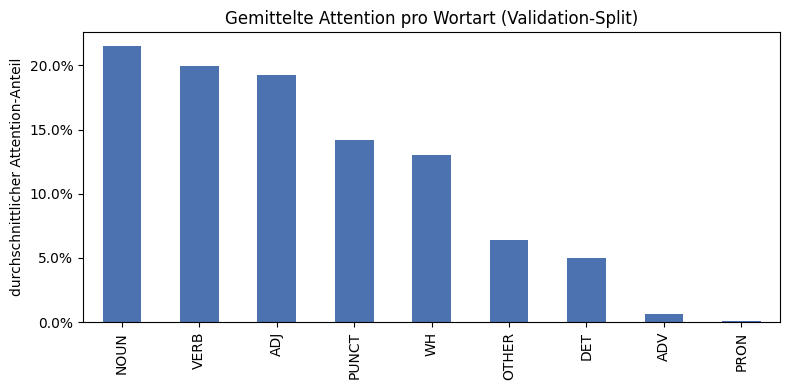

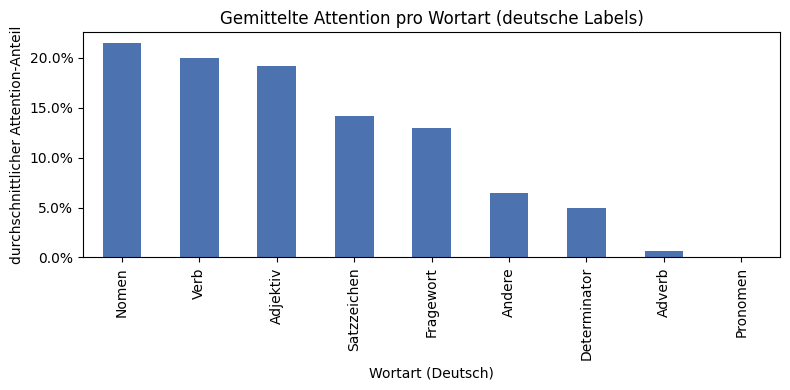

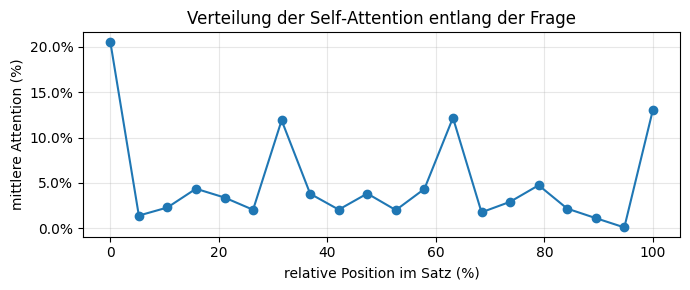

In [7]:
# ----------------------------------------------------------------------------
# Entry‑Point
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    main()